<a href="https://colab.research.google.com/github/cn-mm/SOP-COVID-Tweets-Text-Classification/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the repository 

In [ ]:
# Cloning Repo
!git clone https://github.com/cn-mm/SOP-COVID-Tweets-Text-Classification.git

Cloning into 'SOP-COVID-Tweets-Text-Classification'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 54 (delta 21), reused 20 (delta 7), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [ ]:
# Change directory 
%cd /content/SOP-COVID-Tweets-Text-Classification

/content/SOP-COVID-Tweets-Text-Classification


In [ ]:
# Importing Libraries 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# nltk
import nltk 
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re

import gensim
import string

# Tensorflow 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

# keras
import seaborn as sns
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, Activation 
from keras.initializers import Constant
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Loading and formatting Datasets 

In [ ]:
TRAIN = pd.read_csv(r'/content/SOP-COVID-Tweets-Text-Classification/train1.tsv', sep='\t')
VAL = pd.read_csv(r'/content/SOP-COVID-Tweets-Text-Classification/valid.tsv', sep = '\t')

In [ ]:
def get_label(text):
    if text == "UNINFORMATIVE":
        return 0
    elif text == "INFORMATIVE":
        return 1
    else: 
        return -1

TRAIN['Label'] = TRAIN['Label'].apply(get_label)
VAL['Label'] = VAL['Label'].apply(get_label)

In [ ]:
train = TRAIN
val = VAL

In [ ]:
train.head()
val.head()

,Id,Text,Label
0,1241728922192142336,For those saying Pakistan isn’t Italy; After 3...,0
1,1235713405992030209,Second case DR 🇩🇴 The Canadian woman has not b...,1
2,1245941302367305728,Kill Chain: the cyber war on America's electio...,0
3,1245913002840391681,Town hosts FIRST #Virtual #TownCouncil meeting...,0
4,1240543259299987457,Report suggested that the actual number of und...,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6932 entries, 0 to 6931
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      6932 non-null   int64 
 1   Text    6932 non-null   object
 2   Label   6932 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.6+ KB


In [ ]:
train.groupby('Label').count()

,Id,Text
Label,,
0,3660,3660
1,3272,3272


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Informative and Uninformative Tweets')

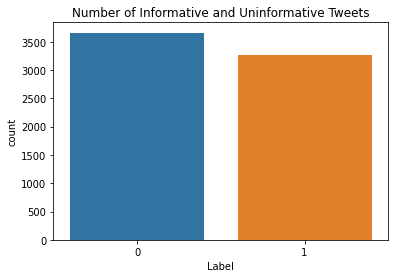

In [ ]:
import seaborn as sns
sns.countplot(train.Label)
plt.xlabel('Label')
plt.title('Number of Informative and Uninformative Tweets')

# RNN Model


## Train and val 


In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len]) # here shape taken as max no. of words in a tweet 
    layer = Embedding(max_words,50,input_length=max_len)(inputs) # input dim = max words, output dim = 50, input len = max_len 
    layer = LSTM(64)(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.8)(layer)
    layer = Dense(1,name='out_layer')(layer) # output layer 
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

# Train and val combined 

In [ ]:
# Combine train and val data and spilt internally 
trainval = train.append(val, ignore_index= True)

In [ ]:
trainval['Text']

0       Official death toll from #covid19 in the Unite...
1       Dearest Mr. President @USER 1,169 coronavirus ...
2       Latest Updates March 20 ⚠️5274 new cases and 3...
3       真把公主不当干部 BREAKING: 21 people on Grand Princess...
4       OKLAHOMA CITY — The State Department of Educat...
                              ...                        
7927    Coronavirus took hold in UK earlier than thoug...
7928    I talked with a man who is Rowan County’s seco...
7929    Governor Wolf delaying enforcement of non-life...
7930    The Sheriff's Department has reduced the jail ...
7931    BREAKING NEWS: 2 possible cases of #COVIDー19 i...
Name: Text, Length: 7932, dtype: object

In [ ]:
le = LabelEncoder()

X = trainval.Text 
Y = trainval.Label
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
print(X, Y)

0       Official death toll from #covid19 in the Unite...
1       Dearest Mr. President @USER 1,169 coronavirus ...
2       Latest Updates March 20 ⚠️5274 new cases and 3...
3       真把公主不当干部 BREAKING: 21 people on Grand Princess...
4       OKLAHOMA CITY — The State Department of Educat...
                              ...                        
7927    Coronavirus took hold in UK earlier than thoug...
7928    I talked with a man who is Rowan County’s seco...
7929    Governor Wolf delaying enforcement of non-life...
7930    The Sheriff's Department has reduced the jail ...
7931    BREAKING NEWS: 2 possible cases of #COVIDー19 i...
Name: Text, Length: 7932, dtype: object [[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [1]]


In [ ]:
max_words = 20000 # generally vocab of the set 
max_len = 80 # actual is around 70/80 
tok = Tokenizer(num_words=max_words) # using keras tokenizer here 
k = tok.fit_on_texts(X)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

Epoch 1/10
50/50 [==============================] - 1s 27ms/step - loss: 0.6836 - accuracy: 0.5623 - val_loss: 0.6104 - val_accuracy: 0.7335
Epoch 2/10
50/50 [==============================] - 1s 20ms/step - loss: 0.3963 - accuracy: 0.8323 - val_loss: 0.3960 - val_accuracy: 0.8299
Epoch 3/10
50/50 [==============================] - 1s 20ms/step - loss: 0.1760 - accuracy: 0.9385 - val_loss: 0.4589 - val_accuracy: 0.8248
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


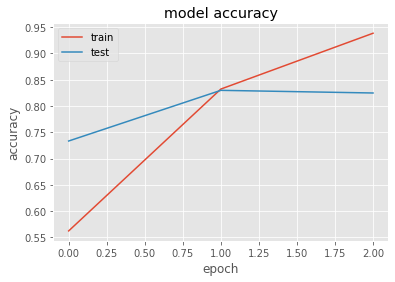

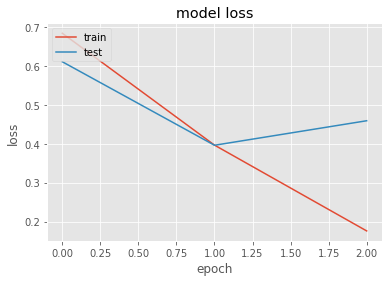

In [ ]:
# create model
model = RNN()
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(sequences_matrix,Y,batch_size=128,epochs=10,validation_split=0.2, shuffle = True , callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
"""
accuracy: 0.9385 - val_loss: 0.4208 - val_accuracy: 0.8248
"""

'\naccuracy: 0.9385 - val_loss: 0.4208 - val_accuracy: 0.8248\n'

# Trying out glove embeddings 

In [ ]:
# Get embedding info from drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/1_SOP_NLP/glove.6B.zip"

Archive:  /content/gdrive/My Drive/1_SOP_NLP/glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [ ]:
!unzip "/content/gdrive/My Drive/1_SOP_NLP/glove.twitter.27B.zip"

Archive:  /content/gdrive/My Drive/1_SOP_NLP/glove.twitter.27B.zip
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  


In [ ]:
# Create corpus, all words in the vocabulary
def create_corpus_new(df):
    corpus=[]
    for tweet in tqdm(df['Text']):
        words=[word.lower() for word in word_tokenize(tweet)]
        # words=[word.lower() for word in TweetTokenizer(tweet)]
        corpus.append(words)
    return corpus 

In [ ]:
# train = TRAIN get training set 
train = TRAIN.append(VAL, ignore_index= True)
corpus=create_corpus_new(train)
print(corpus)
print(len(corpus))

100%|██████████| 7932/7932 [00:03<00:00, 2529.11it/s]


In [ ]:
# Create an embedding dictionary using GloVe vectors 
# word and corresponding vector 
embedding_dict={}

# with open('/content/SOP-COVID-Tweets-Text-Classification/glove.6B.100d.txt','r') as f:
with open('/content/SOP-COVID-Tweets-Text-Classification/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
# To pass to the model and tokenize 
MAX_LEN=80
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post') # padded tweets 

word_index = tokenizer_obj.word_index # word index is the mapping words to integer, will be a dictionary 
print('Number of unique words:',len(word_index))

Number of unique words: 26333


In [ ]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec=embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec           


100%|██████████| 26333/26333 [00:00<00:00, 553932.53it/s]


In [ ]:
tweet_pad[0][0:]

array([  536,    71,   182,    18,     3,    22,     5,     2,   347,
        2522,    15,    54,  1751,    83,    17,   396,   324,  4748,
         324,  1441,   324,  2181,   324,  4078,   324,  2182,   324,
        1093,   324,  2183,   324,  2523,   324,   943,    74,  2963,
           1,   158,    17, 10735,   175,    40,  2184,   276,    39,
        1128,   620,    17,  7321,   175,    40,  5702,   276,    39,
           8,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [ ]:
# model=Sequential()

# embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
#                    input_length=MAX_LEN,trainable=False)

# model.add(embedding)
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))


# optimzer=Adam(learning_rate=3e-4)

# model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=3e-4)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 80, 100)           2633400   
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 2,692,537
Trainable params: 59,137
Non-trainable params: 2,633,400
_________________________________________________________________


In [ ]:
tr = tweet_pad[:train.shape[0]]
te = tweet_pad[train.shape[0]:]
# tweet_pad.shape

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(tr ,train['Label'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6345, 80)
Shape of Validation  (1587, 80)


Epoch 1/5
100/100 - 28s - loss: 0.3199 - accuracy: 0.8586 - val_loss: 0.3474 - val_accuracy: 0.8614
Epoch 2/5
100/100 - 27s - loss: 0.3214 - accuracy: 0.8634 - val_loss: 0.3738 - val_accuracy: 0.8614
Epoch 3/5
100/100 - 27s - loss: 0.3015 - accuracy: 0.8712 - val_loss: 0.3800 - val_accuracy: 0.8658
Epoch 4/5
100/100 - 27s - loss: 0.2953 - accuracy: 0.8736 - val_loss: 0.3697 - val_accuracy: 0.8563
Epoch 5/5
100/100 - 27s - loss: 0.2957 - accuracy: 0.8720 - val_loss: 0.3229 - val_accuracy: 0.8765


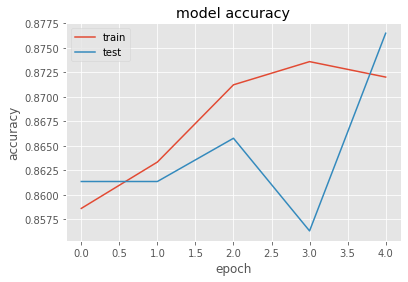

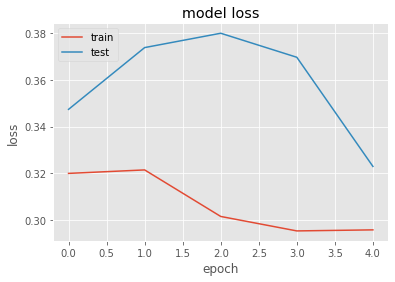

In [ ]:
history=model.fit(X_train,y_train,batch_size=64,epochs=5,validation_data=(X_test,y_test),verbose=2) #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.000001)])

# model.fit(sequences_matrix,Y,batch_size=128,epochs=10,validation_split=0.2, shuffle = True , callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
Epoch 5/5
100/100 - 27s - loss: 0.3209 - accuracy: 0.8638 - val_loss: 0.3337 - val_accuracy: 0.8658
Epoch 5/5
100/100 - 27s - loss: 0.2957 - accuracy: 0.8720 - val_loss: 0.3229 - val_accuracy: 0.8765

# Can do 30 then 